In [1]:
import sys
sys.path.insert(0, '../../py3')

In [2]:
from auxilary3 import Helper as hp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# variables
host='REPLICA'
db_con = hp.DbExplorer(host)

In [4]:
query_pred = """SELECT * 
            FROM weissserver.pos_category_suggestions s, weissserver.pos_bars_products bp
            WHERE s.bar_product_id = bp.id
            and date(created_at) > '2018-01-01'"""

In [5]:
query = """SELECT YEAR(inserted_at) as year, count(*) as match_count
FROM weissserver.pos_bars_products bp
group by YEAR(inserted_at)"""
df_year = pd.DataFrame(db_con.dbreader(query))
df_year

match_count    year
0     212522.0  2016.0
1     919277.0  2017.0
2    3022549.0  2018.0

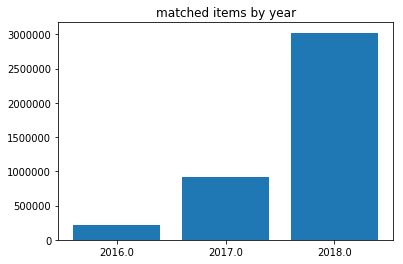

In [21]:
fig, ax = plt.subplots()
x = np.arange(df_year.shape[0])
#ax.yaxis.set_major_formatter(formatter)
plt.bar(x, df_year['match_count'])
plt.xticks(x, df_year['year'])
plt.title('matched items by year')
plt.show()

In [51]:
query = """SELECT MONTH(inserted_at) as month, COUNT(*) AS 'no_category_count'
FROM weissserver.pos_bars_products bp
       JOIN weissserver.bars b ON bp.bar_id = b.id
       JOIN weissserver.breweries_bars bb ON bb.bar_id = b.id
       JOIN weissserver.breweries br ON bb.brewery_id = br.id
WHERE b.status BETWEEN 10 AND 19 AND br.status = 1
and date(inserted_at) > '2018-01-01' and date(inserted_at) < '2018-09-01'
AND (bp.category_id = 0 OR bp.category_id IS NULL)
GROUP BY MONTH(inserted_at)
union
SELECT MONTH(inserted_at) as month, COUNT(*) AS 'no_category_count'
FROM weissserver.pos_bars_products bp
       JOIN weissserver.bars b ON bp.bar_id = b.id
       JOIN weissserver.breweries_bars bb ON bb.bar_id = b.id
       JOIN weissserver.breweries br ON bb.brewery_id = br.id
WHERE b.status BETWEEN 10 AND 19 AND br.status = 1
and date(inserted_at) > '2018-09-01' and date(inserted_at) < '2018-10-01'
AND (bp.category_id = 0 OR bp.category_id IS NULL)
AND br.id != 90
GROUP BY MONTH(inserted_at)"""
df_no_category = pd.DataFrame(db_con.dbreader(query))
df_no_category

month  no_category_count
0    1.0               32.0
1    2.0               25.0
2    3.0               40.0
3    4.0               95.0
4    5.0              149.0
5    6.0              468.0
6    7.0             1101.0
7    8.0             2878.0
8    9.0             3503.0

In [52]:
query = """SELECT MONTH(inserted_at) month, COUNT(*) AS 'item_count'
FROM weissserver.pos_bars_products bp
       JOIN weissserver.bars b ON bp.bar_id = b.id
       JOIN weissserver.breweries_bars bb ON bb.bar_id = b.id
       JOIN weissserver.breweries br ON bb.brewery_id = br.id
WHERE b.status BETWEEN 10 AND 19 AND br.status = 1
and date(inserted_at) > '2018-01-01' and date(inserted_at) < '2018-10-01'
GROUP BY MONTH(inserted_at)"""
df_all_products = pd.DataFrame(db_con.dbreader(query))
df_all_products

item_count  month
0     59321.0    1.0
1    170586.0    2.0
2     88892.0    3.0
3     93702.0    4.0
4    144848.0    5.0
5    252765.0    6.0
6   1188832.0    7.0
7    504781.0    8.0
8    144882.0    9.0

In [53]:
df_product_stats = df_all_products.merge(df_no_category, on ='month')
df_product_stats['match_rate'] = 1 - df_product_stats.no_category_count / df_product_stats.item_count

In [54]:
df_product_stats

item_count  month  no_category_count  match_rate
0     59321.0    1.0               32.0    0.999461
1    170586.0    2.0               25.0    0.999853
2     88892.0    3.0               40.0    0.999550
3     93702.0    4.0               95.0    0.998986
4    144848.0    5.0              149.0    0.998971
5    252765.0    6.0              468.0    0.998148
6   1188832.0    7.0             1101.0    0.999074
7    504781.0    8.0             2878.0    0.994299
8    144882.0    9.0             3503.0    0.975822

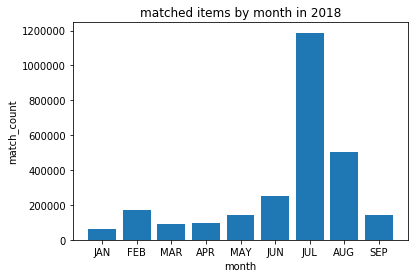

In [59]:
month_list = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP']
fig, ax = plt.subplots()
x = np.arange(df_product_stats.shape[0])
#ax.yaxis.set_major_formatter(formatter)
plt.bar(x, df_product_stats['item_count'] - df_product_stats['no_category_count'])
plt.xticks(x, month_list)
plt.xlabel('month')
plt.ylabel('match_count')
plt.title('matched items by month in 2018')
plt.show()

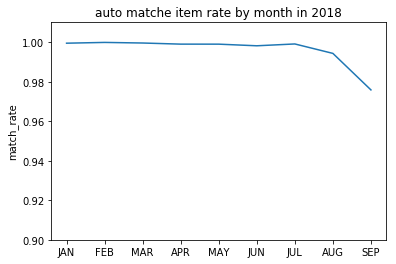

In [60]:
plt.plot(month_list, df_product_stats['match_rate'][0:9])
plt.ylabel('match_rate')
plt.title('auto matche item rate by month in 2018')
plt.ylim(0.9, 1.01)
plt.show()

In [71]:
query = """SELECT
   COALESCE(`br`.`name`, 'Total') AS 'Brewery',
   COUNT(*) AS 'item_count'
FROM
   weissserver.pos_bars_products bp
       JOIN
   weissserver.bars b ON `bp`.`bar_id` = `b`.`id`
       JOIN
   weissserver.breweries_bars bb ON `bb`.`bar_id` = `b`.`id`
       JOIN
   breweries br ON `bb`.`brewery_id` = `br`.`id`
WHERE `b`.`status` BETWEEN 10 AND 19
       AND `br`.`status` = 1
       and date(inserted_at) > '2018-01-01'
GROUP BY `br`.`name`
HAVING item_count > 10000"""
df_all_by_country = pd.DataFrame(db_con.dbreader(query))
df_all_by_country

Brewery  item_count
0   AB-Inbev UK     28588.0
1  AB-Inbev USA    782412.0
2           CUB    390610.0
3       Hooters    526245.0
4        Labatt    575921.0
5            OB    174608.0
6       Quilmes    164642.0

In [72]:
df_all_by_country['Brewery'] = df_all_by_country['Brewery'].apply(lambda name: name.replace('AB-Inbev', ''))

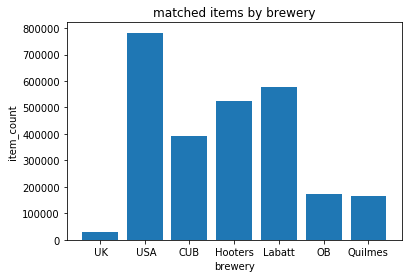

In [73]:
fig, ax = plt.subplots()
x = np.arange(df_all_by_country.shape[0])
#ax.yaxis.set_major_formatter(formatter)
plt.bar(x, df_all_by_country['item_count'])
plt.xticks(x, df_all_by_country['Brewery'])
plt.xlabel('brewery')
plt.ylabel('item_count')
plt.title('matched items by brewery')
plt.show()

In [13]:
# Beer

In [15]:
query = """SELECT MONTH(inserted_at) month, COUNT(*) AS 'item_count'
FROM weissserver.pos_bars_products bp
       JOIN weissserver.bars b ON bp.bar_id = b.id
       JOIN weissserver.breweries_bars bb ON bb.bar_id = b.id
       JOIN weissserver.breweries br ON bb.brewery_id = br.id
WHERE b.status BETWEEN 10 AND 19 AND br.status = 1
and date(inserted_at) > '2018-01-01'
and bp.category_id = 1
GROUP BY MONTH(inserted_at)"""
df_all_beer = pd.DataFrame(db_con.dbreader(query))
df_all_beer

item_count  month
0      8110.0    1.0
1     23232.0    2.0
2     11285.0    3.0
3     11690.0    4.0
4     13383.0    5.0
5     34161.0    6.0
6    136514.0    7.0
7     52770.0    8.0
8     14437.0    9.0
9       132.0   10.0

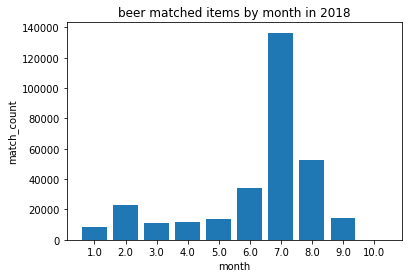

In [23]:
fig, ax = plt.subplots()
x = np.arange(df_all_beer.shape[0])
#ax.yaxis.set_major_formatter(formatter)
plt.bar(x, df_all_beer['item_count'])
plt.xticks(x, df_all_beer['month'])
plt.xlabel('month')
plt.ylabel('match_count')
plt.title('beer matched items by month in 2018')
plt.show()